# protostars
## 21- Extinction power law exponent
### I. Exploratory

Why does it show such a tight clustering around its initial value?

gully  
May 9, 2017

In [1]:
import pandas as pd

In [2]:
ws = np.load('../sf/exp8/output/bb_absolute/run01/emcee_chain.npy')

In [4]:
label = [r"$T_{\mathrm{eff}}$", r"$\log{g}$", r"$[\mathrm{Fe}/\mathrm{H}]$",r"$v_z$", r"$v\sin{i}$", r"$\log{\Omega}$", 
         r"$T_{\mathrm{BB}}$", r"$\log{\Omega_2}$", r"$A_K$", r"$\lambda^\alpha$", r"$c^1$", r"$c^2$", r"$c^3$", r"sigAmp", r"logAmp", r"$l$"] 

Just plot the $\alpha$ MCMC chain.

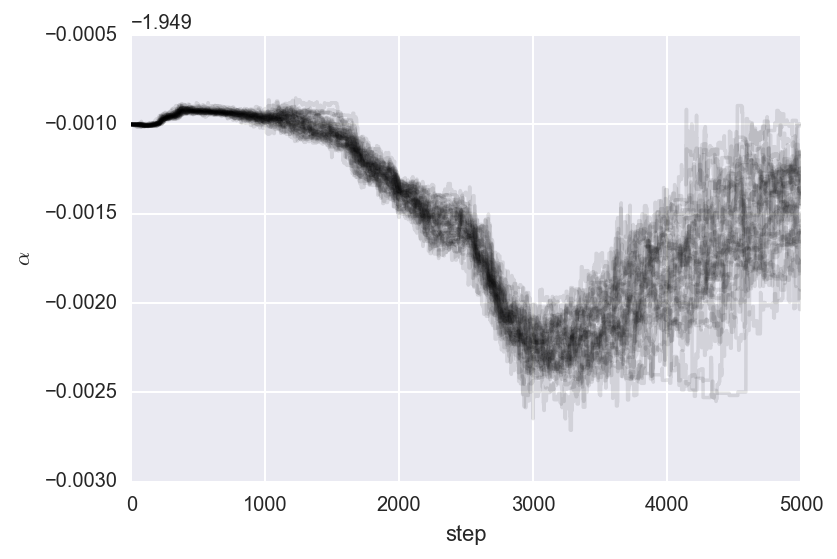

In [7]:
plt.plot(ws[:,:, 9].T, 'k-', alpha=0.1);
plt.ylabel(r'$\alpha$');
plt.xlabel('step');

I think that's the problem-- The MCMC chain is simply not burned in yet.

In [10]:
burned = ws[:, -1000:,:]
xs, ys, zs = burned.shape
fc = burned.reshape(xs*ys, zs)

$\alpha$ does not span the allowable range at all, though it does show correlation

(4.0, 6.0)

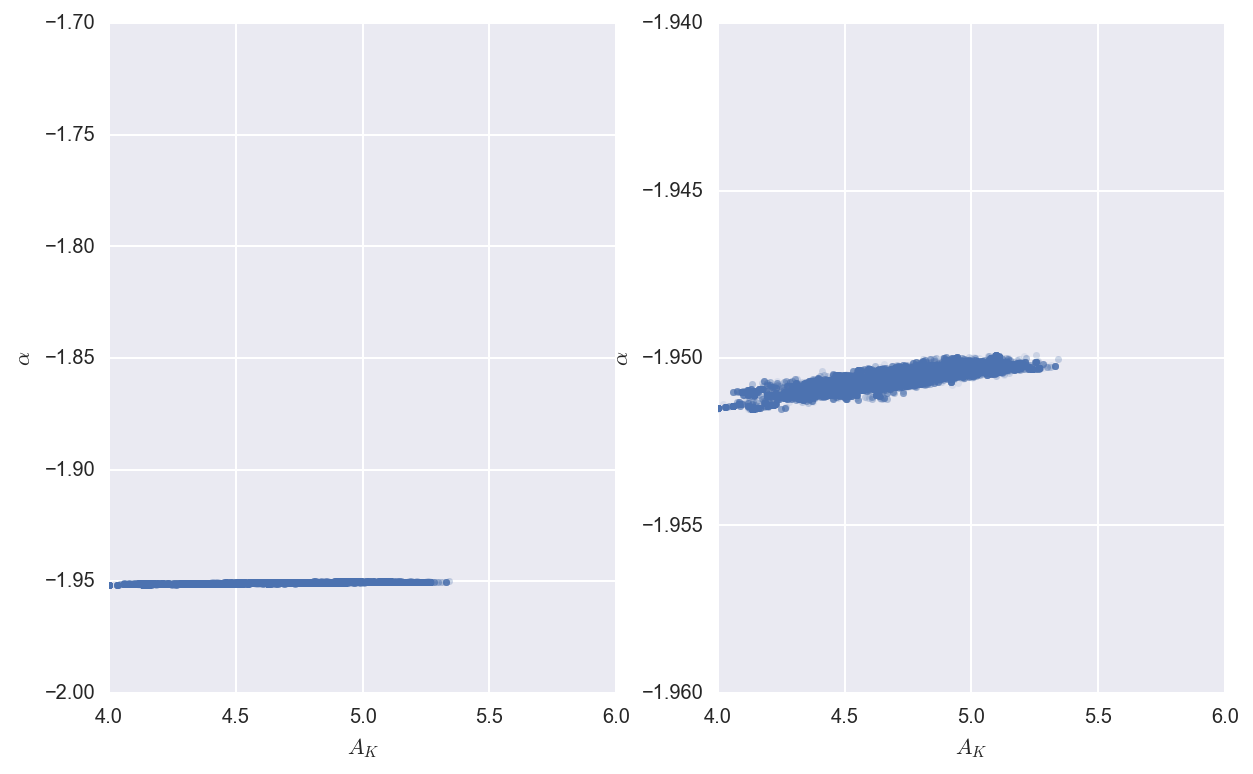

In [14]:
plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.plot(fc[:, 8], fc[:, 9], '.', alpha=0.1);
plt.ylim(-2, -1.7)
plt.xlabel(label[8])
plt.ylabel(r'$\alpha$')
plt.xlim(4.0, 6.0)

plt.subplot(122)
plt.plot(fc[:, 8], fc[:, 9], '.', alpha=0.1);
plt.ylim(-1.96, -1.94)
plt.xlabel(label[8])
plt.ylabel(r'$\alpha$')
plt.xlim(4.0, 6.0)

What do the spectra look like?

In [15]:
raw = np.load('../sf/exp8/output/bb_absolute/run01/raw_models.npy')

In [16]:
raw.shape

(5000, 40)

In [17]:
star, disk, extinc, cheb = (raw[4890][9][i, :] for i in range(4))

In [18]:
import h5py

f = h5py.File("../data/reduced/S68N_NIRSPEC.hdf5", "r")

wl = np.array(f['wls'])
fl = np.array(f['fls'])
sig = np.array(f['sigmas'])

f.close()

Make an example model, before extinction

In [19]:
orig_mod = (star+disk)/extinc

In [20]:
fc.shape

(40000, 16)

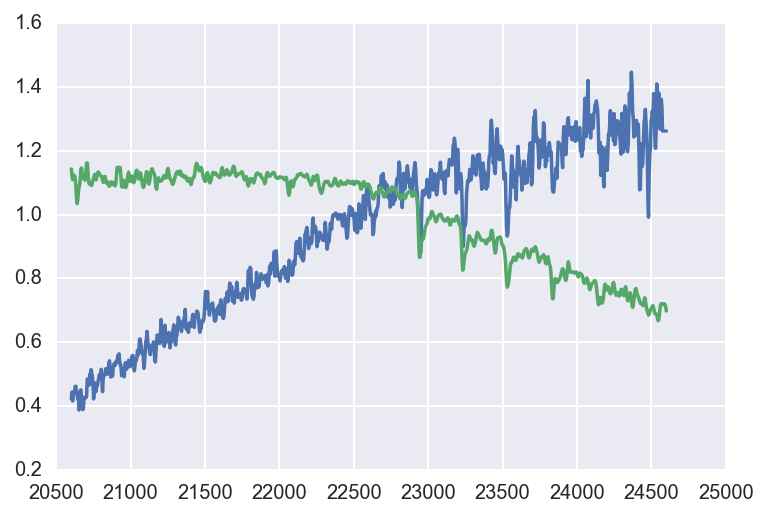

In [21]:
plt.plot(wl, fl)
plt.plot(wl, orig_mod)

In [22]:
def A_lambda(wl, A_K, alpha):
    A_lambda = A_K * (wl/22000.0)**alpha
    return A_lambda

In [23]:
def extinction(wl, A_lam):
    extinc = 10**(-0.4*A_lam)
    return extinc

In [24]:
def reddening(wl, A_lam):
    extinc = extinction(wl, A_lam)
    return extinc/np.mean(extinc)

(0, 2)

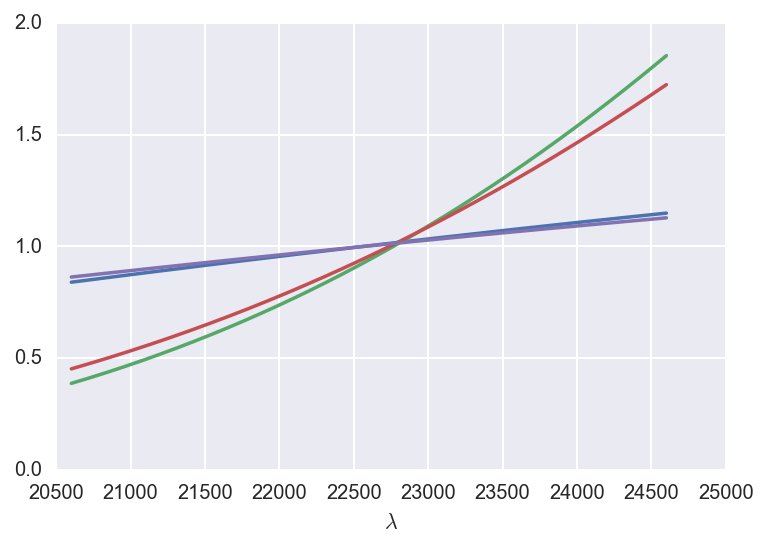

In [25]:
A_lam = A_lambda(wl, 1.0, -2.0)
extinc = extinction(wl, A_lam)
plt.plot(wl, extinc/np.mean(extinc))

A_lam = A_lambda(wl, 5.0, -2.0)
extinc = extinction(wl, A_lam)
plt.plot(wl, extinc/np.mean(extinc))

A_lam = A_lambda(wl, 5.0, -1.7)
extinc = extinction(wl, A_lam)
plt.plot(wl, extinc/np.mean(extinc))

A_lam = A_lambda(wl, 1.0, -1.7)
extinc = extinction(wl, A_lam)
plt.plot(wl, extinc/np.mean(extinc))
plt.xlabel('$\lambda$')
plt.ylim(0, 2)

The power law exponent doesn't really change the spectral shape very much in the range of allowed values!

Let's set up a simple demo of sampling in just these two parameters.

In [26]:
def lnlike(theta):
    A_K, alpha = theta
    if (alpha < -2) | (alpha > -1.7):
        return -np.inf
    A_lam = A_lambda(wl, A_K, alpha)
    red = reddening(wl, A_lam)
    model = orig_mod*red
    inv_sigma2 = 1.0/(sig**2)
    return -0.5*(np.sum((fl-model)**2*inv_sigma2))

In [27]:
ndim, nwalkers = 2, 100
pos = np.array([ (5.0, -1.95) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)])

In [29]:
import emcee

In [30]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, threads=8)

In [31]:
res = sampler.run_mcmc(pos, 5000)

In [32]:
samples = sampler.chain[:, 4000:, :].reshape((-1, ndim))

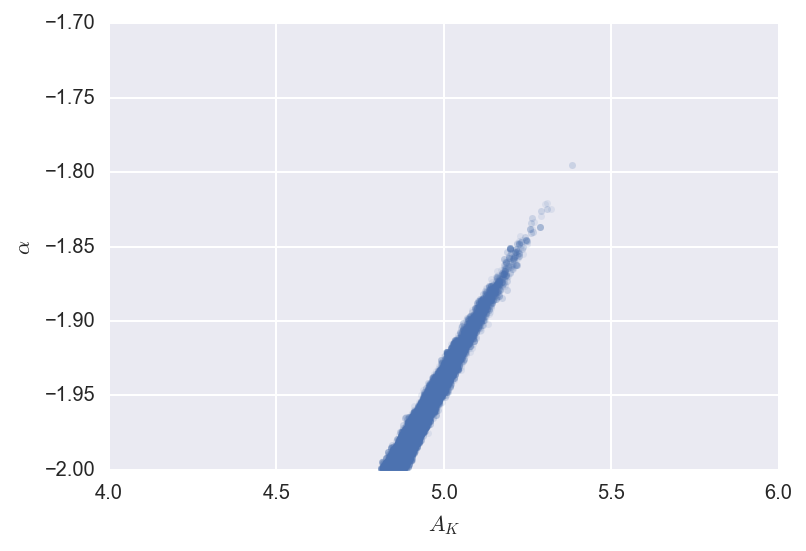

In [37]:
plt.plot(samples[:, 0], samples[:, 1], '.', alpha=0.1)
plt.xlim(4.0, 6.0)
plt.ylim(-2, -1.7)
plt.ylabel(r'$\alpha$')
plt.xlabel(r'$A_K$')

This model can reach the entire range of $\alpha$ values.

Here are random draws from the experiment 8 posterior with the same model draw held fixed.

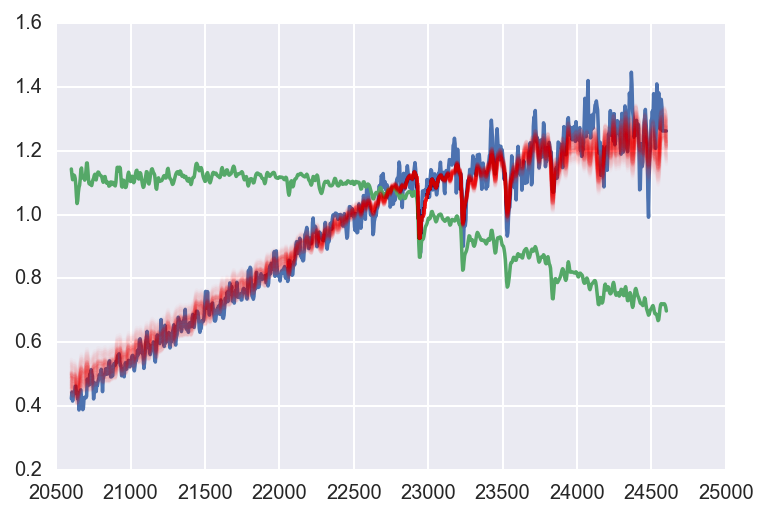

In [39]:
ris = np.random.randint(0, 40000, size=100)

plt.plot(wl, fl)
plt.plot(wl, orig_mod)

for i, ri in enumerate(ris):
    A_K, alpha = fc[ri, [8,9]]
    A_lam = A_lambda(wl, A_K, alpha)
    red = reddening(wl, A_lam)
    plt.plot(wl, orig_mod*red, 'r', alpha=0.02)

Here are random draws from the toy model posterior:

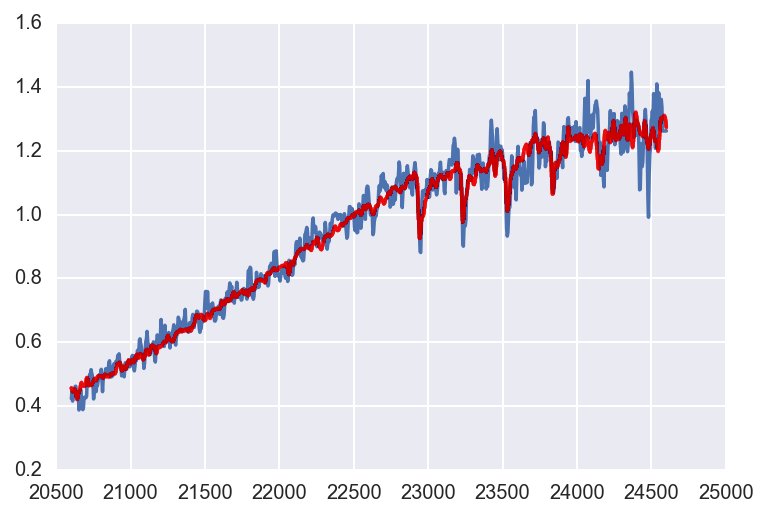

In [40]:
ris = np.random.randint(0, 100000, size=100)

plt.plot(wl, fl)

for i, ri in enumerate(ris):
    A_K, alpha = samples[ri, :]
    A_lam = A_lambda(wl, A_K, alpha)
    red = reddening(wl, A_lam)
    plt.plot(wl, orig_mod*red, 'r', alpha=0.02)

So yeah, it looks like the problem is that I simply didn't let the MCMC chain burn in long enough.  
This is also a manifestation of the fact that I initialized the sample ball with a teeny-tiny distriution, so it took them a long time to random walk into a larger sample ball.

My recommendation is to `--resume` the sampling and call it `exp8 run02`